In [1]:
%pip install imbalanced-learn
%pip install nltk 
%pip install spacy 
%pip install numpy==1.21.0 
%pip install gensim
%pip install --upgrade scikit-learn
%pip install --upgrade matplotlib
%pip install --upgrade pandas
%pip install --upgrade seaborn
%pip install fasttext
%pip install spacy
%pip install wordcloud

import spacy
spacy.cli.download("en_core_web_sm")
nlp = spacy.load('en_core_web_sm')


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Using cached numpy-1.21.0.zip (10.3 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
ERROR: Exception:
Traceback (most recent call last):
  File "/Users/manitk/Desktop/SEM_V/ML_Project/.venv/lib/python3.12/site-packages/pip/_internal/cli/base_command.py", line 105, in _run_wrapper
    status = _inner_run()
     


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import nltk

random.seed(42)
nltk.download('punkt_tab')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import class_weight
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/manitk/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/manitk/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/manitk/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /Users/manitk/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!
[nltk_data] Downloading package words to /Users/manitk/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/manitk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/manitk/nltk_data...
[nltk_data]   Package wordnet i

In [3]:
## DATA CLEANING AND PREPROCESSING

data1 = "/Users/manitk/Desktop/SEM_V/ML_Project/Datasets/bug_severity/eclipse.csv"
data2 = "/Users/manitk/Desktop/SEM_V/ML_Project/Datasets/bug_severity/mozilla.csv"

df1 = pd.read_csv(data1)
df2 = pd.read_csv(data2)
df = pd.concat([df1, df2], ignore_index=True)
description = df['description'] 
severity = df['severity']
new_data = pd.DataFrame({'description': description, 'severity': severity})
new_data = new_data.dropna()

# removing normal & enhancement severity
new_data = new_data[new_data.severity != "normal"]
new_data = new_data[new_data.severity != "ehancement"]
new_data = new_data[new_data.severity != '']
new_data = new_data[new_data.severity != 'Optional']
print(new_data.head())
print("Number of rows in data =", new_data.shape[0])
print("Sample per Class =\n", new_data['severity'].value_counts())
X = new_data['description']
Y = new_data['severity']

# # test-train split
# x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.25, stratify=Y, random_state=42)
# print("Number of rows in train data =", x_train.shape[0])
# print("Number of rows in test data =", x_test.shape[0])

                                         description  severity
0              Stack overflow with namespace aliases  critical
1  CApplicationLaunchShortcut call to ebugUITools...   trivial
2  unpredictable switcheing between "all" and "cl...     major
3  unpredictable switching between "all" and "cle...  critical
4  Eclipse blocks at startup due to saved open CD...   blocker
Number of rows in data = 55121
Sample per Class =
 severity
major       20414
critical    18935
minor        9928
trivial      4329
blocker      1515
Name: count, dtype: int64


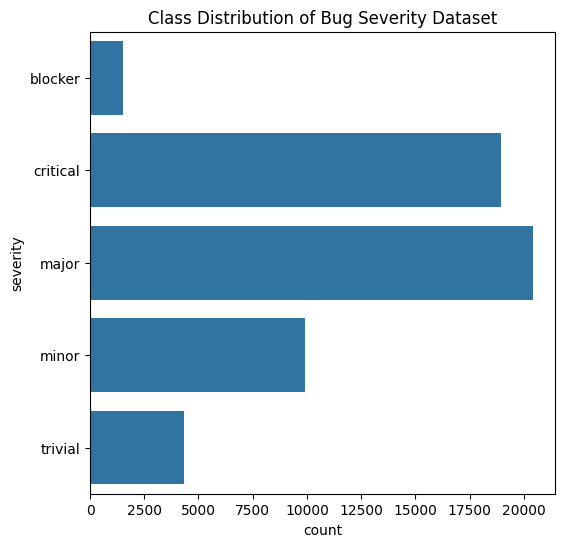

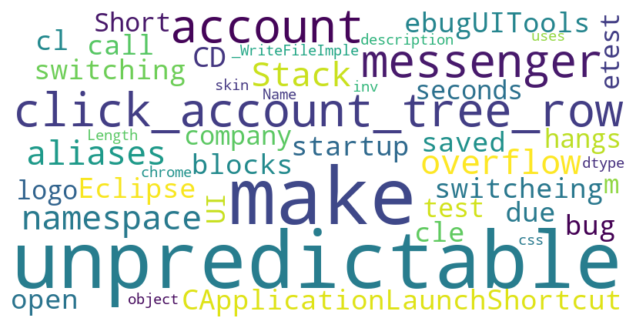

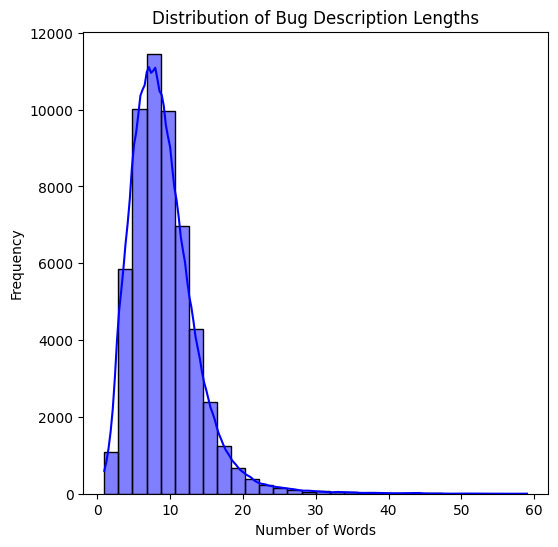

In [4]:
# EDA

# 1. Class Distribution
plt.figure(figsize=(6,6))
severity_order = ['blocker', 'critical', 'major', 'minor', 'trivial']
sns.countplot(Y, order=severity_order)
plt.title('Class Distribution of Bug Severity Dataset')
plt.show()

# 2. Word Cloud
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(str(X))
plt.figure(figsize=(8,4))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# 3. Description Length
description_lengths = X.apply(lambda x: len(x.split()))
plt.figure(figsize=(6, 6))
sns.histplot(description_lengths, bins=30, kde=True, color='blue')
plt.title('Distribution of Bug Description Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [5]:
# PREPROCESSING & FEATURE EXTRACTION
from nltk.tokenize import word_tokenize
def preprocess_text(description):
    tokens = word_tokenize(description)
    tokens = [word.lower() for word in tokens]
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

def handling_class_imbalance(Y):
    classes = np.unique(Y)
    class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=Y)
    class_weights_dict = {classes[i]: class_weights[i] for i in range(len(class_weights))}
    return class_weights_dict

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
print("Number of samples in train data =", X_train.shape[0])
print("Number of samples in test data =", X_test.shape[0])

print("First Sample before preprocessing: ",X_train[0])
X_train = X_train.apply(lambda x: preprocess_text(x))
X_test = X_test.apply(lambda x: preprocess_text(x))
print("First Sample after preprocessing: ",X_train[0])

# Feature Extraction
# TFIFD Vectorizer with Unigrams & Bigrams
vectorizer = TfidfVectorizer(ngram_range=(1,2))
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
print("Number of features after feature extraction =", X_train.shape[1])

# dimensionality reduction
svd = TruncatedSVD(n_components=1000)
X_train = svd.fit_transform(X_train)
X_test = svd.transform(X_test)

Number of samples in train data = 41340
Number of samples in test data = 13781
First Sample before preprocessing:  Stack overflow with namespace aliases
First Sample after preprocessing:  stack overflow namespace alias
Number of features after feature extraction = 173984


In [32]:
# Logistic Regression Classifier

log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of Logistic Regression Classifier =", accuracy)
print(classification_report(y_test, y_pred))


/Users/manitk/Desktop/SEM_V/ML_Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy of Logistic Regression Classifier = 0.6000290254698498
              precision    recall  f1-score   support

     blocker       0.68      0.16      0.25       405
    critical       0.77      0.71      0.74      4621
       major       0.54      0.76      0.63      5217
       minor       0.47      0.32      0.38      2476
     trivial       0.48      0.18      0.26      1062

    accuracy                           0.60     13781
   macro avg       0.59      0.42      0.45     13781
weighted avg       0.60      0.60      0.58     13781



In [7]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier( random_state=42, max_depth=100)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of Decision Tree Classifier =", accuracy)
print(classification_report(y_test, y_pred))



Accuracy of Decision Tree Classifier = 0.4398809955736159
              precision    recall  f1-score   support

     blocker       0.18      0.20      0.19       405
    critical       0.59      0.60      0.59      4621
       major       0.47      0.44      0.46      5217
       minor       0.27      0.28      0.28      2476
     trivial       0.18      0.19      0.18      1062

    accuracy                           0.44     13781
   macro avg       0.34      0.34      0.34     13781
weighted avg       0.44      0.44      0.44     13781



In [20]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier( random_state=42, max_depth=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of Random Forest Classifier =", accuracy)
print(classification_report(y_test, y_pred))



Accuracy of Random Forest Classifier = 0.573615847906538
              precision    recall  f1-score   support

     blocker       0.89      0.16      0.28       405
    critical       0.75      0.67      0.71      4621
       major       0.50      0.83      0.62      5217
       minor       0.47      0.14      0.21      2476
     trivial       0.54      0.07      0.13      1062

    accuracy                           0.57     13781
   macro avg       0.63      0.37      0.39     13781
weighted avg       0.59      0.57      0.53     13781



In [19]:
# MLP Classifier
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100,50), max_iter=1000, random_state=42,activation='tanh',solver='sgd')
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of MLP Classifier =", accuracy)
print(classification_report(y_test, y_pred))


Accuracy of MLP Classifier = 0.5923372759596546
              precision    recall  f1-score   support

     blocker       0.43      0.23      0.30       405
    critical       0.76      0.72      0.74      4621
       major       0.56      0.67      0.61      5217
       minor       0.43      0.37      0.40      2476
     trivial       0.42      0.28      0.33      1062

    accuracy                           0.59     13781
   macro avg       0.52      0.45      0.48     13781
weighted avg       0.59      0.59      0.58     13781



In [22]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators=[
    ('lr', log_reg), 
    ('dt', dt), 
    ('rf', rf), 
    ('mlp', mlp)
], voting='hard')  # Use 'hard' for majority voting (or 'soft' for weighted average)

voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of Majority Voting Classifier =", accuracy)
print(classification_report(y_test, y_pred))

/Users/manitk/Desktop/SEM_V/ML_Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy of Majority Voting Classifier = 0.5953123866192584
              precision    recall  f1-score   support

     blocker       0.65      0.19      0.29       405
    critical       0.74      0.73      0.74      4621
       major       0.53      0.78      0.63      5217
       minor       0.49      0.22      0.31      2476
     trivial       0.51      0.14      0.22      1062

    accuracy                           0.60     13781
   macro avg       0.58      0.41      0.44     13781
weighted avg       0.59      0.60      0.56     13781



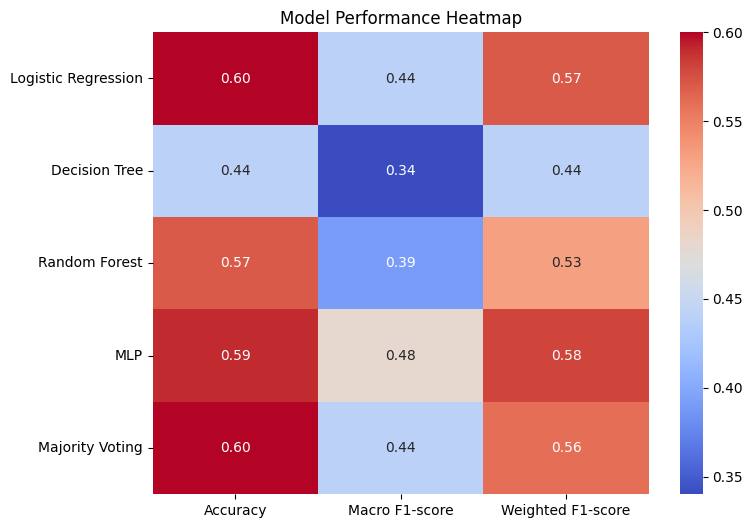

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Data
data = np.array([
    [0.60, 0.44, 0.57],  # Logistic Regression
    [0.44, 0.34, 0.44],  # Decision Tree
    [0.57, 0.39, 0.53],  # Random Forest
    [0.59, 0.48, 0.58],   # MLP
    [0.60,0.44,0.56] # Majority Voting
])

models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'MLP', 'Majority Voting']
metrics = ['Accuracy', 'Macro F1-score', 'Weighted F1-score']

# Create the heatmap
plt.figure(figsize=(8,6))
sns.heatmap(data, annot=True, xticklabels=metrics, yticklabels=models, cmap='coolwarm', cbar=True, fmt='.2f')

plt.title('Model Performance Heatmap')
plt.show()


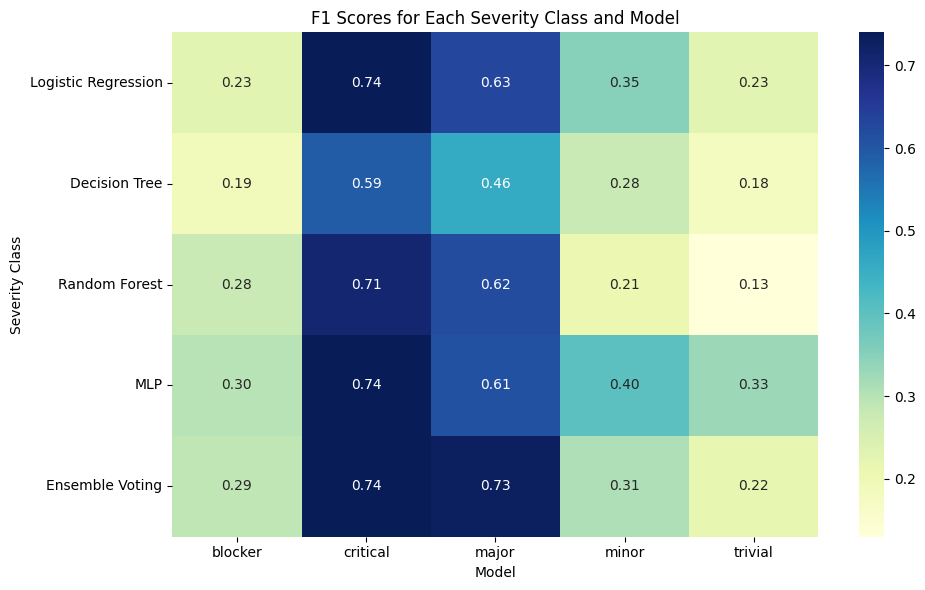

In [25]:
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'MLP', 'Ensemble Voting']
severity_classes = ['blocker', 'critical', 'major', 'minor', 'trivial']

f1_scores = np.array([
    [0.23,0.74,0.63,0.35,0.23],  # Logistic Regression
    [0.19,0.59,0.46,0.28,0.18],  # Decision Tree
    [0.28,0.71,0.62,0.21,0.13],  # Random Forest
    [0.30,0.74,0.61,0.40,0.33],  # MLP
    [0.29,0.74,0.73,0.31,0.22]   # Ensemble Voting
])

plt.figure(figsize=(10, 6))
sns.heatmap(f1_scores, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=severity_classes, yticklabels=models)
plt.xlabel('Model')
plt.ylabel('Severity Class')
plt.title('F1 Scores for Each Severity Class and Model')
plt.tight_layout()
plt.show()

In [ ]:
# SUBMITTED IN MID SEM
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import TruncatedSVD
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import nltk

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    processed_text = ' '.join(tokens)
    doc = nlp(text)
    entities = ' '.join([ent.text for ent in doc.ents])
    enriched_text = processed_text + ' ' + entities
    
    return enriched_text

X = [preprocess_text(text) for text in X]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

print("Class distribution in training set:", Counter(y_train))
print("Class distribution in test set:", Counter(y_test))

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2),max_features=5000, min_df=5, max_df=0.9)),  # TF-IDF with n-grams 
    ('lsa', TruncatedSVD(n_components=200)),  # Latent Semantic Analysis (LSA)
    ('logreg', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000))  # Logistic Regression class_weight = class_weights_dict
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:\n", classification_report(y_test, y_pred))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/manitk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/manitk/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/manitk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 348.6 kB/s eta 0:00:0000:0100:02
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Class distribution in training set: Counter({'critical': 13098, 'major': 12203, 'minor': 5764, 'trivial': 2379, 'blocker': 648})
Class distribution in test set: Counter({'critical': 4305, 'major': 4104, 'minor': 1940, 'trivial': 826, 'blocker': 190})


/Users/manitk/Desktop/SEM V/ML_Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.6026396832380114
Classification Report:
               precision    recall  f1-score   support

     blocker       0.58      0.18      0.27       190
    critical       0.79      0.72      0.75      4305
       major       0.51      0.79      0.62      4104
       minor       0.44      0.21      0.29      1940
     trivial       0.45      0.09      0.14       826

    accuracy                           0.60     11365
   macro avg       0.56      0.40      0.42     11365
weighted avg       0.60      0.60      0.57     11365



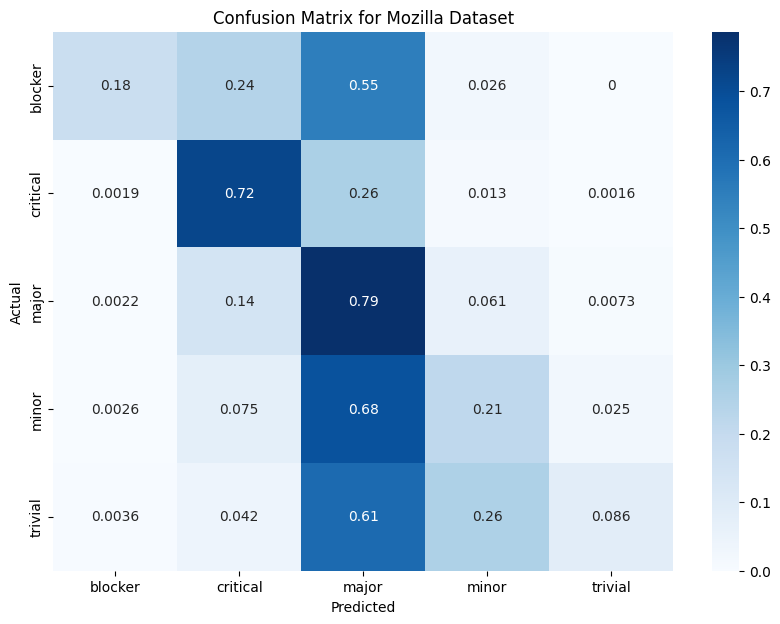

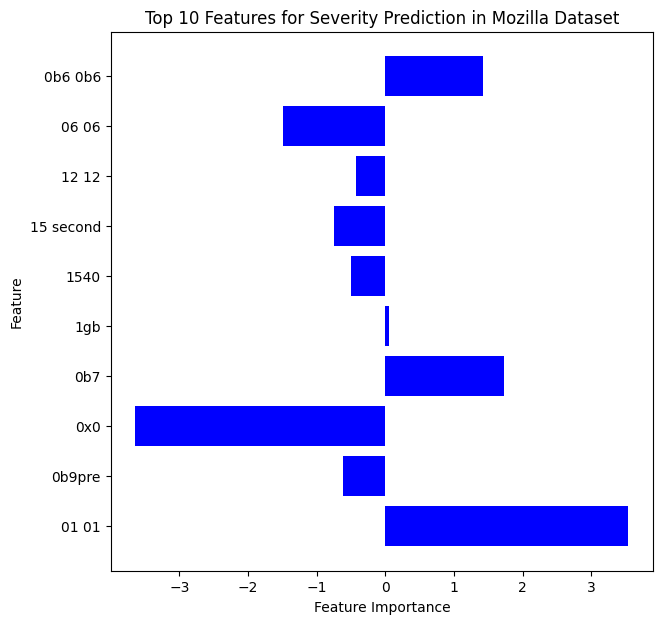

In [ ]:
# graphs to portray the results

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# give percentages in the confusion matrix instead of number
cm = confusion_matrix(y_test,y_pred,normalize='true')
plt.figure(figsize=(10,7))
classes = pipeline.classes_
sns.heatmap(cm, annot=True, xticklabels=classes, yticklabels=classes, cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Mozilla Dataset')
plt.show()

# plot the feature importance
vectorizer = pipeline.named_steps['tfidf']
logreg = pipeline.named_steps['logreg']
feature_names = vectorizer.get_feature_names_out()
coefs = logreg.coef_
plt.figure(figsize=(7,7))
plt.barh(range(10), coefs[0, :10], color='b', align='center')
plt.yticks(range(10), [feature_names[i] for i in np.argsort(coefs[0])[:10]])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')

plt.title('Top 10 Features for Severity Prediction in Mozilla Dataset')
plt.show()


In [8]:
import spacy
nlp = spacy.load("en_core_web_md")
text = "[1.5][compiler] 3.4RC4 java compiler fails to correctly erase generic type information"
doc = nlp(text)
entities = [(ent.text, ent.label_) for ent in doc.ents]
print("Extracted Entities:")
for entity in entities:
    print(f"Entity: {entity[0]}, Label: {entity[1]}")
print(entities)
print("\nOriginal Text:")
print(text)

# example of TF-IDF with n-grams
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Sample corpus
corpus = [
    "The quick brown fox jumps over the lazy dog",
    "The quick brown fox jumps over the quick dog",
    "Dog is brown and lazy"
]

# Initialize the TF-IDF vectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 2))
tfidf_matrix = tfidf.fit_transform(corpus)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

print("TF-IDF with n-grams:")
print(tfidf_df)

Extracted Entities:
Entity: 1.5][compiler, Label: CARDINAL
Entity: 3.4RC4, Label: CARDINAL
[('1.5][compiler', 'CARDINAL'), ('3.4RC4', 'CARDINAL')]

Original Text:
[1.5][compiler] 3.4RC4 java compiler fails to correctly erase generic type information
TF-IDF with n-grams:
        and  and lazy     brown  brown and  brown fox       dog    dog is  \
0  0.000000  0.000000  0.175128   0.000000   0.225509  0.175128  0.000000   
1  0.000000  0.000000  0.162159   0.000000   0.208809  0.162159  0.000000   
2  0.370725  0.370725  0.218956   0.370725   0.000000  0.218956  0.370725   

        fox  fox jumps        is  ...      lazy  lazy dog      over  over the  \
0  0.225509   0.225509  0.000000  ...  0.225509  0.296517  0.225509  0.225509   
1  0.208809   0.208809  0.000000  ...  0.000000  0.000000  0.208809  0.208809   
2  0.000000   0.000000  0.370725  ...  0.281946  0.000000  0.000000  0.000000   

      quick  quick brown  quick dog       the  the lazy  the quick  
0  0.225509     0.225509  